In [1]:
import numpy as np
import seaborn as sns
import zipfile
import os
import cv2


from tensorflow.keras.models import load_model,save_model,model_from_json,Sequential,Model
from tensorflow.keras.layers import Conv2D,Dense,Flatten,GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading The Images

In [2]:
path = "/content/drive/MyDrive/OpenCV/Datasets/homer_bart_2.zip"
zip_object = zipfile.ZipFile(file = path , mode = "r")
zip_object.extractall("./")
zip_object.close()

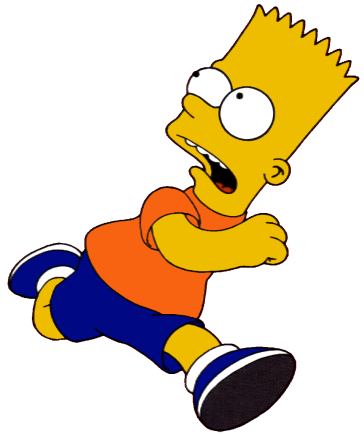

In [3]:
load_img("/content/homer_bart_2/training_set/bart/bart100.bmp")

# Train And Test Set

In [4]:
training_generator = ImageDataGenerator(rescale = 1./255,
                                        rotation_range = 7,
                                        horizontal_flip=True,
                                        zoom_range = 0.2)

train_data = training_generator.flow_from_directory("/content/homer_bart_2/training_set",
                                                    shuffle = True,
                                                    target_size = (256,256),
                                                    class_mode = "categorical",
                                                    batch_size = 8)

Found 215 images belonging to 2 classes.


In [5]:
test_generator = ImageDataGenerator(rescale = 1./255)

test_data = test_generator.flow_from_directory("/content/homer_bart_2/test_set",
                                               shuffle = False,
                                               target_size = (256,256),
                                               class_mode = "categorical",
                                               batch_size = 1)

Found 54 images belonging to 2 classes.


In [6]:
test_data.classes,test_data.class_indices

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), {'bart': 0, 'homer': 1})

# Pre-Trained Network

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [8]:
base_model = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (256,256,3)))

In [9]:
len(base_model.layers)

175

In [10]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [11]:
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe072ad7e90> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe07647c550> True
<keras.layers.convolutional.Conv2D object at 0x7fe072a5cdd0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe0729e2d10> True
<keras.layers.core.activation.Activation object at 0x7fe0729aded0> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe072b0e310> True
<keras.layers.pooling.MaxPooling2D object at 0x7fe072760bd0> True
<keras.layers.convolutional.Conv2D object at 0x7fe0726fc750> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe072703550> True
<keras.layers.core.activation.Activation object at 0x7fe072707410> True
<keras.layers.convolutional.Conv2D object at 0x7fe0726fcf10> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe07271b610> True
<keras.layers.core.activation.Activation object at 0x7fe072715810> True
<keras.layer

In [12]:
for layer in base_model.layers:
    layer.trainable = False
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe072ad7e90> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe07647c550> False
<keras.layers.convolutional.Conv2D object at 0x7fe072a5cdd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe0729e2d10> False
<keras.layers.core.activation.Activation object at 0x7fe0729aded0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe072b0e310> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe072760bd0> False
<keras.layers.convolutional.Conv2D object at 0x7fe0726fc750> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe072703550> False
<keras.layers.core.activation.Activation object at 0x7fe072707410> False
<keras.layers.convolutional.Conv2D object at 0x7fe0726fcf10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe07271b610> False
<keras.layers.core.activation.Activation object at 0x7fe072715810> False

# Custom Dense Layer

In [13]:
base_model.output, base_model.input

(<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>,
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>)

In [14]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation = "relu")(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1025, activation = "relu")(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units= 2 ,activation = "softmax")(head_model)
head_model

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_2')>

# Building And Training The Neural Network

In [15]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [16]:
model = Model(inputs = base_model.input, outputs = head_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
model.compile(optimizer = "Adam", metrics = ["accuracy"], loss = "categorical_crossentropy")
history = model.fit(train_data, epochs = 50 , validation_data = test_data)

Epoch 1/50
27/27 [==============================] - 25s 514ms/step - loss: 1.4855 - accuracy: 0.5395 - val_loss: 0.7351 - val_accuracy: 0.5185
Epoch 2/50
27/27 [==============================] - 8s 283ms/step - loss: 0.6825 - accuracy: 0.6140 - val_loss: 0.6896 - val_accuracy: 0.5185
Epoch 3/50
27/27 [==============================] - 6s 216ms/step - loss: 0.6577 - accuracy: 0.6419 - val_loss: 0.6996 - val_accuracy: 0.5000
Epoch 4/50
27/27 [==============================] - 6s 217ms/step - loss: 0.6804 - accuracy: 0.6140 - val_loss: 0.6546 - val_accuracy: 0.6667
Epoch 5/50
27/27 [==============================] - 6s 217ms/step - loss: 0.6575 - accuracy: 0.6140 - val_loss: 0.6235 - val_accuracy: 0.6852
Epoch 6/50
27/27 [==============================] - 6s 216ms/step - loss: 0.6122 - accuracy: 0.6512 - val_loss: 0.5896 - val_accuracy: 0.7222
Epoch 7/50
27/27 [==============================] - 6s 216ms/step - loss: 0.6253 - accuracy: 0.6465 - val_loss: 0.5627 - val_accuracy: 0.7407
Epoch

# Evaluating The Neural Network

In [18]:
def history_graph(history, epochs):

    plt.figure(figsize = (10,6))

    plt.subplot(121)
    plt.plot(history.history["accuracy"],label = "Train")
    plt.plot(history.history["val_accuracy"],label = "Validation")
    plt.legend(loc = "best")
    plt.title("Accuracy Score")
    plt.xticks(range(1,epochs+1,3), rotation = 90)

    plt.subplot(122)
    plt.plot(history.history["loss"],label = "Train")
    plt.plot(history.history["val_loss"],label = "Validation")
    plt.legend(loc = "best")
    plt.title("Loss Score")
    plt.xticks(range(1,epochs+1,3), rotation = 90)

    plt.tight_layout()
    plt.show()

def confusion_graph(y_test,y_pred):

    cm = confusion_matrix(y_test,y_pred)

    plt.figure(figsize = (10,5))
    sns.heatmap(cm, annot = True, fmt = "d", cbar = False, linewidth = 0.4, linecolor="white", annot_kws = {"size" : 20})
    plt.ylabel("Actual",fontsize = 15)
    plt.xlabel("Predicted",fontsize = 15)
    plt.title("Confusion Matrix Graph", fontsize = 15)
    plt.show()

In [19]:
model.evaluate(test_data)

54/54 [==============================] - 2s 44ms/step - loss: 0.4857 - accuracy: 0.8333


[0.48566359281539917, 0.8333333134651184]

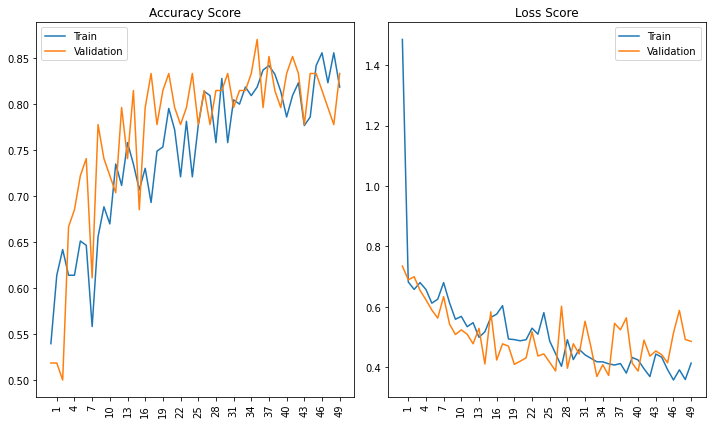

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

history_graph(history, epochs = 50)

In [21]:
test_data.class_indices

{'bart': 0, 'homer': 1}

In [22]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis = 1)

y_pred[:10]

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0])

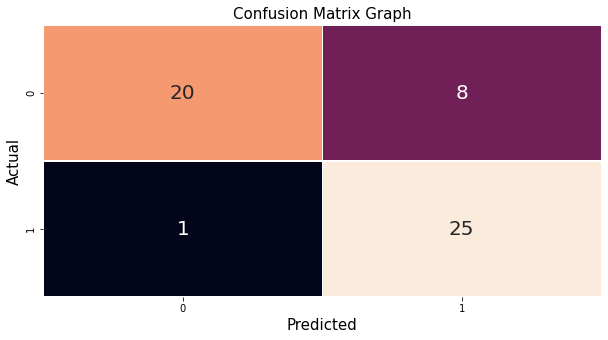

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

confusion_graph(test_data.classes, y_pred)

In [24]:
print(classification_report(test_data.classes, y_pred))
print()
print("Accuracy : {}".format(accuracy_score(test_data.classes, y_pred)))

              precision    recall  f1-score   support

           0       0.95      0.71      0.82        28
           1       0.76      0.96      0.85        26

    accuracy                           0.83        54
   macro avg       0.85      0.84      0.83        54
weighted avg       0.86      0.83      0.83        54


Accuracy : 0.8333333333333334


# Fine Tuning

In [25]:
base_model.trainable = True
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe072ad7e90> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe07647c550> True
<keras.layers.convolutional.Conv2D object at 0x7fe072a5cdd0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe0729e2d10> True
<keras.layers.core.activation.Activation object at 0x7fe0729aded0> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fe072b0e310> True
<keras.layers.pooling.MaxPooling2D object at 0x7fe072760bd0> True
<keras.layers.convolutional.Conv2D object at 0x7fe0726fc750> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe072703550> True
<keras.layers.core.activation.Activation object at 0x7fe072707410> True
<keras.layers.convolutional.Conv2D object at 0x7fe0726fcf10> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe07271b610> True
<keras.layers.core.activation.Activation object at 0x7fe072715810> True
<keras.layer

In [26]:
len(base_model.layers)

175

In [27]:
fine_tuning_at = 140

In [28]:
# Model Değişiyor !!!

for layer in base_model.layers[:fine_tuning_at]:
    layer.trainable = False

for layer in base_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [29]:
for layer in model.layers:
   print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [30]:
model.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

fining_history = model.fit(train_data, epochs = 50, validation_data = test_data)

Epoch 1/50
27/27 [==============================] - 14s 333ms/step - loss: 3.9952 - accuracy: 0.6186 - val_loss: 7.2481 - val_accuracy: 0.5185
Epoch 2/50
27/27 [==============================] - 6s 223ms/step - loss: 0.7364 - accuracy: 0.6140 - val_loss: 0.7152 - val_accuracy: 0.6852
Epoch 3/50
27/27 [==============================] - 6s 226ms/step - loss: 0.6717 - accuracy: 0.6837 - val_loss: 5.5602 - val_accuracy: 0.5185
Epoch 4/50
27/27 [==============================] - 7s 269ms/step - loss: 0.6285 - accuracy: 0.6186 - val_loss: 4.0675 - val_accuracy: 0.5185
Epoch 5/50
27/27 [==============================] - 10s 369ms/step - loss: 0.5281 - accuracy: 0.7349 - val_loss: 5.3192 - val_accuracy: 0.5185
Epoch 6/50
27/27 [==============================] - 8s 274ms/step - loss: 0.5477 - accuracy: 0.7256 - val_loss: 1.4483 - val_accuracy: 0.5185
Epoch 7/50
27/27 [==============================] - 6s 227ms/step - loss: 0.5205 - accuracy: 0.8047 - val_loss: 0.3003 - val_accuracy: 0.9074
Epoc

In [31]:
# [0.48566359281539917, 0.8333333134651184] Fine Tuning öncesi

model.evaluate(test_data)

54/54 [==============================] - 2s 30ms/step - loss: 0.8995 - accuracy: 0.8148


[0.8994866013526917, 0.8148148059844971]

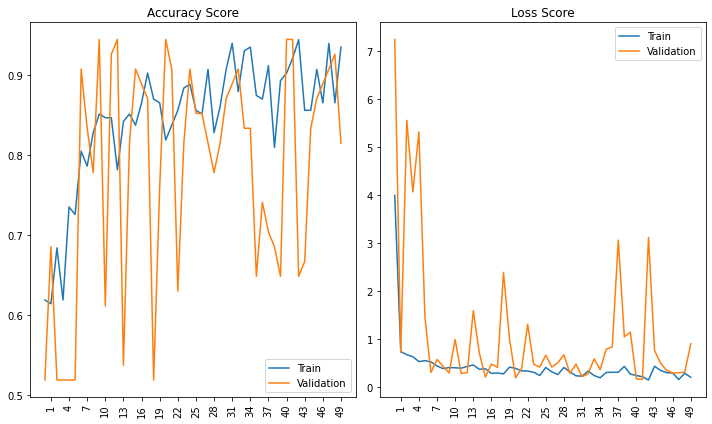

In [32]:
history_graph(fining_history, epochs = 50)

In [33]:
fining_y_pred = model.predict(test_data)
fining_y_pred = np.argmax(fining_y_pred, axis = 1)

fining_y_pred[:10]

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0])

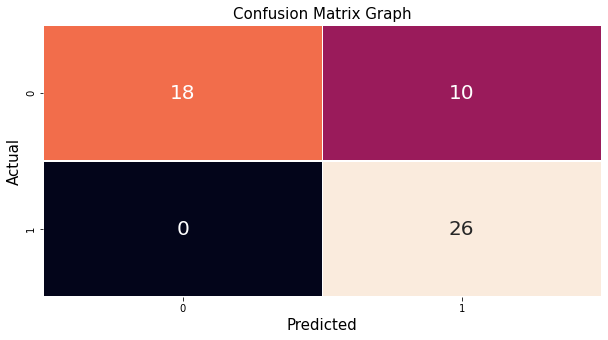

In [34]:
confusion_graph(test_data.classes, fining_y_pred)

In [35]:
print(classification_report(test_data.classes,fining_y_pred))
print()
print("Accuracy : {}".format(accuracy_score(test_data.classes,fining_y_pred)))

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        28
           1       0.72      1.00      0.84        26

    accuracy                           0.81        54
   macro avg       0.86      0.82      0.81        54
weighted avg       0.87      0.81      0.81        54


Accuracy : 0.8148148148148148


# Saving Loading and Classifying One Single Image

In [36]:
model_json = model.to_json()

with open("model_json","w") as json_file:
    json_file.write(model_json)

json_file.closed

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


True

In [37]:
save_model(model,"model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [38]:
with open("model_json","r") as file:
    model_read = file.read()

file.closed

True

In [39]:
model_load = model_from_json(model_read)
model_load.load_weights("model.h5")
model_load.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = "Adam")
model_load.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [40]:
import cv2
path = "/content/homer_bart_2/test_set/homer/homer15.bmp"
image = cv2.imread(path)
image = cv2.resize(image , (256,256))
image = image / 255
image = image.reshape((1,256,256,3))
results = model_load.predict(image)
results = np.argmax(results)

if results == 0 :
    print("Bart")

else:
    print("Homer")

Homer


# HomeWork

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2

from google.colab.patches import cv2_imshow
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
path = '/content/drive/MyDrive/OpenCV/Datasets/cat_dog_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,GlobalAveragePooling2D

In [44]:
training_generator  = ImageDataGenerator(rescale = 1. / 255,
                                         horizontal_flip = True,
                                         rotation_range = 7,
                                         zoom_range = 0.2)

train_dataset = training_generator.flow_from_directory("/content/cat_dog_2/training_set",
                                                       target_size = (128,128),
                                                       shuffle = True,
                                                       batch_size = 128,
                                                       class_mode = "binary")

Found 4000 images belonging to 2 classes.


In [45]:
test_generator  = ImageDataGenerator(rescale = 1. / 255)

test_dataset = test_generator.flow_from_directory("/content/cat_dog_2/test_set",
                                                       target_size = (128,128),
                                                       shuffle = False,
                                                       batch_size = 1,
                                                       class_mode = "binary")

Found 1000 images belonging to 2 classes.


In [46]:
from tensorflow.keras.applications import MobileNetV2

In [47]:
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (128,128,3))

base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [48]:
for layer in base_model.layers:
    layer.trainable = False

In [49]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 641, activation = "relu")(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 641, activation = "relu")(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1, activation = "sigmoid")(head_model)

head_model

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>

In [50]:
model = Model(inputs = base_model.input, outputs = head_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [51]:
model.compile(loss = "binary_crossentropy",metrics = ["accuracy"], optimizer = "Adam")
hom_history = model.fit(train_dataset, epochs = 5 , validation_data = test_dataset)

Epoch 1/5
32/32 [==============================] - 42s 1s/step - loss: 0.3168 - accuracy: 0.8795 - val_loss: 0.1149 - val_accuracy: 0.9530
Epoch 2/5
32/32 [==============================] - 37s 1s/step - loss: 0.1123 - accuracy: 0.9542 - val_loss: 0.0977 - val_accuracy: 0.9620
Epoch 3/5
32/32 [==============================] - 37s 1s/step - loss: 0.0926 - accuracy: 0.9613 - val_loss: 0.0862 - val_accuracy: 0.9660
Epoch 4/5
32/32 [==============================] - 37s 1s/step - loss: 0.0790 - accuracy: 0.9685 - val_loss: 0.0917 - val_accuracy: 0.9660
Epoch 5/5
32/32 [==============================] - 37s 1s/step - loss: 0.0765 - accuracy: 0.9705 - val_loss: 0.1113 - val_accuracy: 0.9600


In [52]:
model.evaluate(test_dataset)

1000/1000 [==============================] - 14s 14ms/step - loss: 0.1113 - accuracy: 0.9600


[0.11131760478019714, 0.9599999785423279]

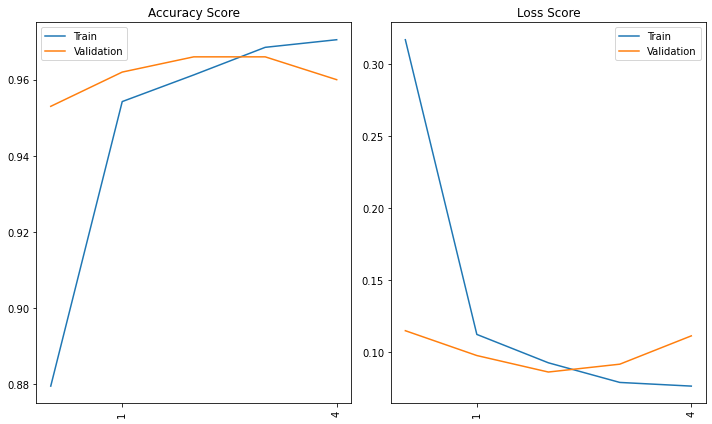

In [53]:
history_graph(hom_history,epochs = 5)

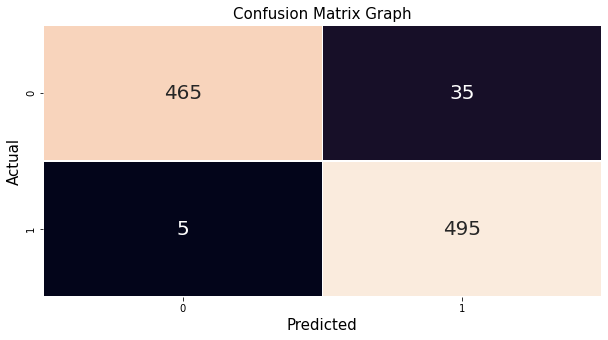

In [54]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

y_pred = model.predict(test_dataset)
y_pred = (y_pred > 0.5)

confusion_graph(test_dataset.classes,  y_pred)

In [55]:
print(classification_report(test_dataset.classes, y_pred))
print()
print("Accuracy : {}".format(accuracy_score(test_dataset.classes,  y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       500
           1       0.93      0.99      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


Accuracy : 0.96


# Fine Tuning

In [56]:
base_model.trainable = True

In [57]:
len(base_model.layers)

154

In [58]:
at_fine_tuning = 100

for layer in base_model.layers[:at_fine_tuning]:
    layer.trainable = False

for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdf7df5bc10> False
<keras.layers.convolutional.Conv2D object at 0x7fdf877e6a90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdf8781cc10> False
<keras.layers.advanced_activations.ReLU object at 0x7fdf7df00c90> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fdf7e3a52d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fe0730f9410> False
<keras.layers.advanced_activations.ReLU object at 0x7fdf7e41f0d0> False
<keras.layers.convolutional.Conv2D object at 0x7fdf7e1f6b10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdf7e3515d0> False
<keras.layers.convolutional.Conv2D object at 0x7fdf7e351190> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdf7e126790> False
<keras.layers.advanced_activations.ReLU object at 0x7fe072b911d0> False
<keras.layers.convolutional.ZeroPadding2D 

In [59]:
model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics = ['accuracy'])

fining_history = model.fit_generator(train_dataset, epochs = 5 ,validation_data = test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
32/32 [==============================] - 43s 1s/step - loss: 0.2278 - accuracy: 0.9137 - val_loss: 0.6866 - val_accuracy: 0.8970
Epoch 2/5
32/32 [==============================] - 37s 1s/step - loss: 0.0773 - accuracy: 0.9682 - val_loss: 0.9789 - val_accuracy: 0.9090
Epoch 3/5
32/32 [==============================] - 42s 1s/step - loss: 0.0758 - accuracy: 0.9750 - val_loss: 0.6797 - val_accuracy: 0.9440
Epoch 4/5
32/32 [==============================] - 38s 1s/step - loss: 0.0573 - accuracy: 0.9812 - val_loss: 4.1390 - val_accuracy: 0.8340
Epoch 5/5
32/32 [==============================] - 37s 1s/step - loss: 0.0570 - accuracy: 0.9818 - val_loss: 3.1304 - val_accuracy: 0.9180


In [60]:
# [0.11131760478019714, 0.9599999785423279] Fine Tuning Öncesi

model.evaluate(test_dataset)

1000/1000 [==============================] - 15s 15ms/step - loss: 3.1304 - accuracy: 0.9180


[3.1303958892822266, 0.9179999828338623]

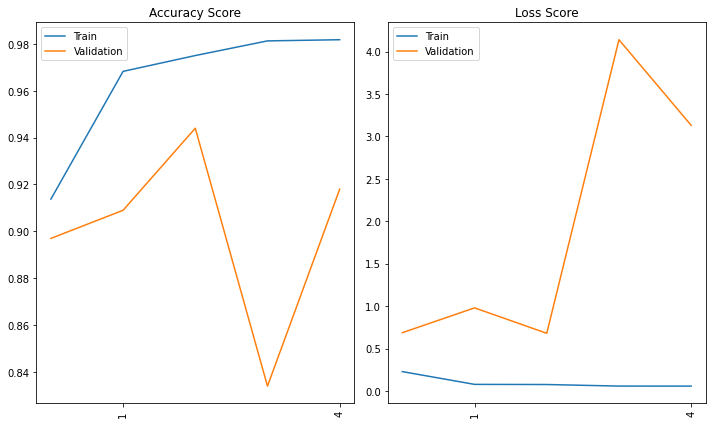

In [61]:
history_graph(fining_history,5)

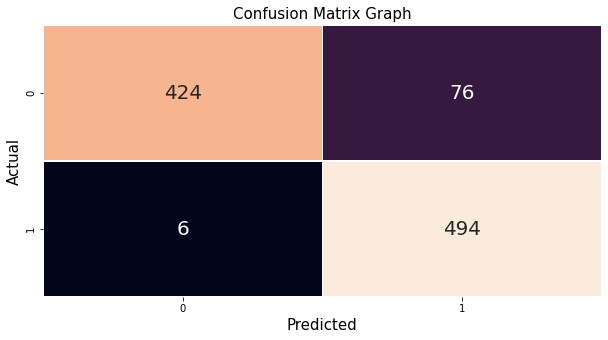

In [62]:
fining_y_pred = model.predict(test_dataset)
fining_y_pred = (fining_y_pred > 0.5)

confusion_graph(test_dataset.classes, fining_y_pred)

In [63]:
print(classification_report(test_dataset.classes, fining_y_pred))
print()
print("Accuracy : {}".format(accuracy_score(test_dataset.classes,  fining_y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91       500
           1       0.87      0.99      0.92       500

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000


Accuracy : 0.918
